<h1>Text Sentiment Analysis for Twitter Posts</h1>

Objective:
- Find out the different sentiment levels (negative, neutral, positive) among the posts and generate word clouds to discover key motivations / beliefs driving the sentiments

In [1]:
# pip install vaderSentiment

In [2]:
# pip install boto3

In [3]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import plotly.express as px
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.style as style
import matplotlib
import matplotlib.pyplot as plt

In [4]:
analyser = SentimentIntensityAnalyzer()

In [5]:
# https://github.com/cjhutto/vaderSentiment#about-the-scoring
# positive sentiment: compound score >= 0.05
# neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
# negative sentiment: compound score <= -0.05

def sentiment_analyzer_score(sentence):
    score = analyser.polarity_scores(sentence)
    return score['compound']

In [6]:
# Read Twitter Data from Local CSV

# tweets = pd.read_csv('./Twitter_Data/Twitter_Covid-19_Lockdown_100.csv', index_col=0)

# print(tweets.shape)
# tweets.head()

In [7]:
# Read Twitter Data from S3 

import pandas as pd
import boto3
import io

AWS_ACCESS_KEY_ID = "*"
AWS_SECRET_ACCESS_KEY = "*"
bucket = "is434-last-sem-best-sem"
file_name = "data-lake/tweeter_data.csv"

# Create connection to S3 and all buckets within S3
s3 = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
)

# Get object and file (key) from bucket
obj = s3.get_object(Bucket= bucket, Key= file_name) 

tweets = pd.read_csv(io.BytesIO(obj['Body'].read()))
tweets

,created_at,context_annotations,text,id,edit_history_tweet_ids
0,2023-03-25T19:15:57.000Z,"[{'domain': {'id': '123', 'name': 'Ongoing New...","Atomisation of the sociological kind, by @rowe...",1639707710458413058,['1639707710458413058']
1,2023-03-25T19:15:49.000Z,"[{'domain': {'id': '46', 'name': 'Business Tax...",#Covid19India 🇮🇳 The Children of Nowhere / The...,1639707678250336264,['1639707678250336264']
2,2023-03-25T18:48:32.000Z,"[{'domain': {'id': '123', 'name': 'Ongoing New...",Absolutely awesome presentation of covid n it'...,1639700812061622273,['1639700812061622273']
3,2023-03-25T18:46:49.000Z,"[{'domain': {'id': '123', 'name': 'Ongoing New...",Me after seeing the tweets from the 1st Lockdo...,1639700378831974400,['1639700378831974400']
4,2023-03-25T18:31:57.000Z,"[{'domain': {'id': '123', 'name': 'Ongoing New...","The operative words are ""No Plan"" ...let's rem...",1639696640175906817,['1639696640175906817']
...,...,...,...,...,...
95,2023-03-24T07:14:39.000Z,"[{'domain': {'id': '123', 'name': 'Ongoing New...",T01 - Today marks the third anniversary of Cov...,1639163801638518786,['1639163801638518786']
96,2023-03-24T06:33:34.000Z,"[{'domain': {'id': '123', 'name': 'Ongoing New...",@AnnieCshandbag @Conservatives Covid19 curtain...,1639153462746251265,['1639153462746251265']
97,2023-03-24T06:30:00.000Z,"[{'domain': {'id': '69', 'name': 'News Vertica...",Stranded in #Vishakhapatnam during the 2020 #l...,1639152566805364736,['1639152566805364736']
98,2023-03-24T06:28:12.000Z,"[{'domain': {'id': '123', 'name': 'Ongoing New...","I wanted to sleep a little more, but COVID-19....",1639152114474840067,['1639152114474840067']


In [8]:
# Extract Text from DataFrame into a List

tweet_text_list = tweets['text'].tolist()
tweet_text_list

['Atomisation of the sociological kind, by @rowena_slope https://t.co/brZBSGzIZ1 \n#COVID19 #Lockdown https://t.co/sUmIrSKCAu',
 '#Covid19India 🇮🇳 The Children of Nowhere / The Nowhere children documentary - on the devastating effects on school children in India during #Covid19 #lockdown. Documentary in the link. A @collateralglbl production. English subtitles. #debate #coronavirus \n\nhttps://t.co/TpeeE1y3L6 https://t.co/zLhlvCZXei',
 "Absolutely awesome presentation of covid n it's side effects, shown by brilliant director @anubhavsinha in #Bheed movie, after cutting so many scenes by #CBFCwatch, awesome acting by #rajkumarRao #abhijeet #ashitoshrana &amp; #pankajKapoor #Bheedreview #MustWatch #COVID19 #Lockdown",
 'Me after seeing the tweets from the 1st Lockdown\n\n#coronavirus #COVID19 https://t.co/TEfqCFHZ1a',
 'The operative words are "No Plan" ...let\'s remember that....\n\n#shanghai #Lockdown one year ago\n#COVID19 https://t.co/xdgngbOgET',
 'I talked to a friend about doing s

In [9]:
# Clean Text Function

stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]

def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = temp.split()
    temp = [w for w in temp if not w in stopwords]
    temp = " ".join(word for word in temp)
    return temp

In [10]:
# Extract processed text

processed_text = [clean_tweet(tw) for tw in tweet_text_list]
processed_text

<ipython-input-9-1602e8e0e335>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


['atomisation sociological kind by',
 'children nowhere nowhere children documentary devastating effects school children india during documentary link production english subtitles',
 'absolutely awesome presentation covid n its side effects shown by brilliant director movie after cutting so many scenes by awesome acting by amp',
 'me after seeing tweets 1st lockdown',
 'operative words are no plan lets remember that one year ago',
 'i talked friend about doing something cure cancer but road was bright',
 '2023 movie review wear mask your eyes avoid this infection rating 3 10',
 '14th fa cup was won with emerys team nothing says he wouldnt have won it 1st context covid19 lockdown gift fa if you want know ill explain uefa rules el places donkey artetas place would have won that fa cup since',
 'professor neil ferguson predicts bird flu kill 3 x times more people uk than covid19 get ready next pandemic lockdown guys',
 'cant believe its been year since world went into lockdown whats bigge

In [11]:
# Add processed text into the DataFrame

tweets['processed_text'] = processed_text

In [12]:
# Extract processed tweets column

tweets_list = tweets['processed_text'].tolist()
tweets_list[:10]

['atomisation sociological kind by',
 'children nowhere nowhere children documentary devastating effects school children india during documentary link production english subtitles',
 'absolutely awesome presentation covid n its side effects shown by brilliant director movie after cutting so many scenes by awesome acting by amp',
 'me after seeing tweets 1st lockdown',
 'operative words are no plan lets remember that one year ago',
 'i talked friend about doing something cure cancer but road was bright',
 '2023 movie review wear mask your eyes avoid this infection rating 3 10',
 '14th fa cup was won with emerys team nothing says he wouldnt have won it 1st context covid19 lockdown gift fa if you want know ill explain uefa rules el places donkey artetas place would have won that fa cup since',
 'professor neil ferguson predicts bird flu kill 3 x times more people uk than covid19 get ready next pandemic lockdown guys',
 'cant believe its been year since world went into lockdown whats bigge

In [13]:
# Get a list of sentiment scores for tweets

sentiment_score_list = []
for sentence in tweets_list:
    sentiment_score = sentiment_analyzer_score(str(sentence))
    sentiment_score_list.append(sentiment_score)

sentiment_score_list[:10]

[0.5267, 0.5334, 0.9152, 0.0, -0.296, 0.5023, -0.296, 0.7005, -0.7003, 0.0]

In [14]:
# Add 'sentiment_score' column

tweets['sentiment_score'] = sentiment_score_list
tweets.head()

,created_at,context_annotations,text,id,edit_history_tweet_ids,processed_text,sentiment_score
0,2023-03-25T19:15:57.000Z,"[{'domain': {'id': '123', 'name': 'Ongoing New...","Atomisation of the sociological kind, by @rowe...",1639707710458413058,['1639707710458413058'],atomisation sociological kind by,0.5267
1,2023-03-25T19:15:49.000Z,"[{'domain': {'id': '46', 'name': 'Business Tax...",#Covid19India 🇮🇳 The Children of Nowhere / The...,1639707678250336264,['1639707678250336264'],children nowhere nowhere children documentary ...,0.5334
2,2023-03-25T18:48:32.000Z,"[{'domain': {'id': '123', 'name': 'Ongoing New...",Absolutely awesome presentation of covid n it'...,1639700812061622273,['1639700812061622273'],absolutely awesome presentation covid n its si...,0.9152
3,2023-03-25T18:46:49.000Z,"[{'domain': {'id': '123', 'name': 'Ongoing New...",Me after seeing the tweets from the 1st Lockdo...,1639700378831974400,['1639700378831974400'],me after seeing tweets 1st lockdown,0.0000
4,2023-03-25T18:31:57.000Z,"[{'domain': {'id': '123', 'name': 'Ongoing New...","The operative words are ""No Plan"" ...let's rem...",1639696640175906817,['1639696640175906817'],operative words are no plan lets remember that...,-0.2960


In [15]:
# Label sentiments (positive, negative, neutral) based on sentiment_score for each tweet

tweets['sentiment_score'].apply(lambda x: float(x))
tweets['sentiment_label'] = 'NA'
tweets.loc[tweets.sentiment_score == 0, 'sentiment_label'] = 'neutral'
tweets.loc[tweets.sentiment_score < 0, 'sentiment_label'] = 'negative'
tweets.loc[tweets.sentiment_score > 0, 'sentiment_label'] = 'positive'

tweets.head()

,created_at,context_annotations,text,id,edit_history_tweet_ids,processed_text,sentiment_score,sentiment_label
0,2023-03-25T19:15:57.000Z,"[{'domain': {'id': '123', 'name': 'Ongoing New...","Atomisation of the sociological kind, by @rowe...",1639707710458413058,['1639707710458413058'],atomisation sociological kind by,0.5267,positive
1,2023-03-25T19:15:49.000Z,"[{'domain': {'id': '46', 'name': 'Business Tax...",#Covid19India 🇮🇳 The Children of Nowhere / The...,1639707678250336264,['1639707678250336264'],children nowhere nowhere children documentary ...,0.5334,positive
2,2023-03-25T18:48:32.000Z,"[{'domain': {'id': '123', 'name': 'Ongoing New...",Absolutely awesome presentation of covid n it'...,1639700812061622273,['1639700812061622273'],absolutely awesome presentation covid n its si...,0.9152,positive
3,2023-03-25T18:46:49.000Z,"[{'domain': {'id': '123', 'name': 'Ongoing New...",Me after seeing the tweets from the 1st Lockdo...,1639700378831974400,['1639700378831974400'],me after seeing tweets 1st lockdown,0.0000,neutral
4,2023-03-25T18:31:57.000Z,"[{'domain': {'id': '123', 'name': 'Ongoing New...","The operative words are ""No Plan"" ...let's rem...",1639696640175906817,['1639696640175906817'],operative words are no plan lets remember that...,-0.2960,negative


In [16]:
# Get number of tweets for each sentiment

tweets_per_sentiment = tweets.groupby(['sentiment_label']).size().reset_index(name='num_posts')
tweets_per_sentiment

,sentiment_label,num_posts
0,negative,43
1,neutral,26
2,positive,31


In [17]:
tweets_per_sentiment['percentage_of_total'] = tweets_per_sentiment['num_posts'].apply(lambda x: round(x / tweets.shape[0], 2) * 100)
tweets_per_sentiment

,sentiment_label,num_posts,percentage_of_total
0,negative,43,43.0
1,neutral,26,26.0
2,positive,31,31.0


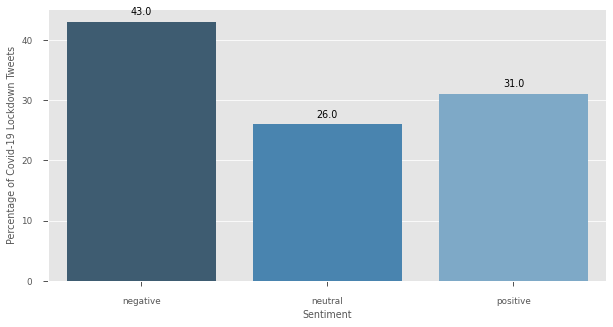

In [18]:
# Visualise percentage of posts with each sentiment

#### Plot settings ####
style.use('seaborn-poster') # sets the size of the charts
style.use('ggplot')
matplotlib.rcParams['font.family'] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = [10, 5]
sns.set_context('paper')

ax = sns.barplot(x="sentiment_label",
                 y="percentage_of_total",
                 data=tweets_per_sentiment,
                 palette=("Blues_d")
                )

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax.set(xlabel='Sentiment', ylabel='Percentage of Covid-19 Lockdown Tweets')

plt.savefig('./Twitter_Output/twitter_lockdown_sentiment.png', dpi=400, bbox_inches="tight")

In [19]:
# Word Cloud Function

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def generate_word_cloud(dataframe, category):
    comment_words = ''
    processed_text = dataframe['processed_text']
    
    # iterate through list
    for tweet_text in processed_text:
        # split the text into tokens
        tokens = tweet_text.split()
        # Append tokens to string comment_words
        comment_words += " ".join(tokens)+" "

    # make a word cloud
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='black', colormap='rainbow',
                    #stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the word cloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()
    wordcloud.to_file(f'./Twitter_Output/twitter_lockdown_wordcloud_{category}.png')

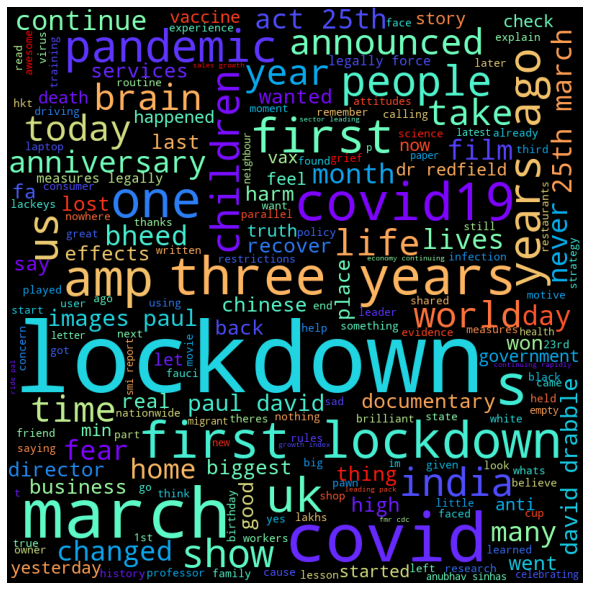

In [20]:
# All Sentiment Word Cloud

generate_word_cloud(tweets, 'all')

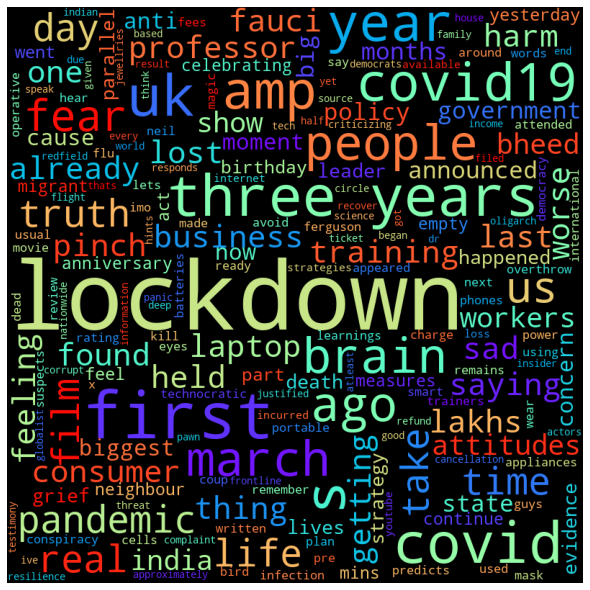

In [21]:
# Negative Sentiment DataFrame

negative = tweets[tweets['sentiment_label'] == 'negative']
generate_word_cloud(negative, 'negative')

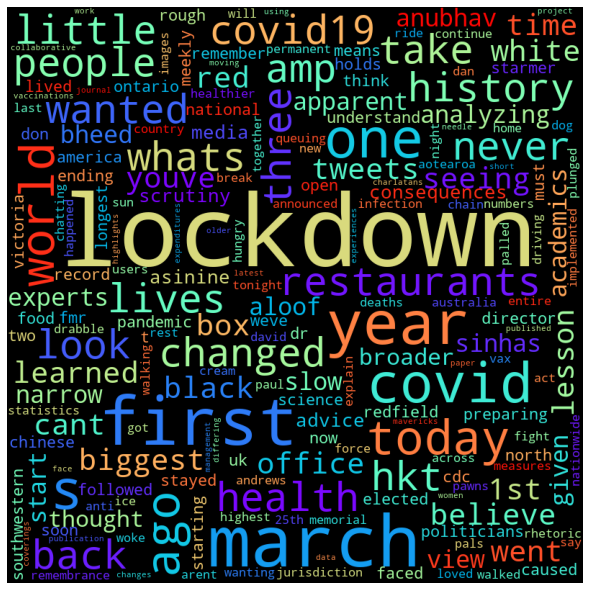

In [22]:
# Neutral Sentiment DataFrame

neutral = tweets[tweets['sentiment_label'] == 'neutral']
generate_word_cloud(neutral, 'neutral')

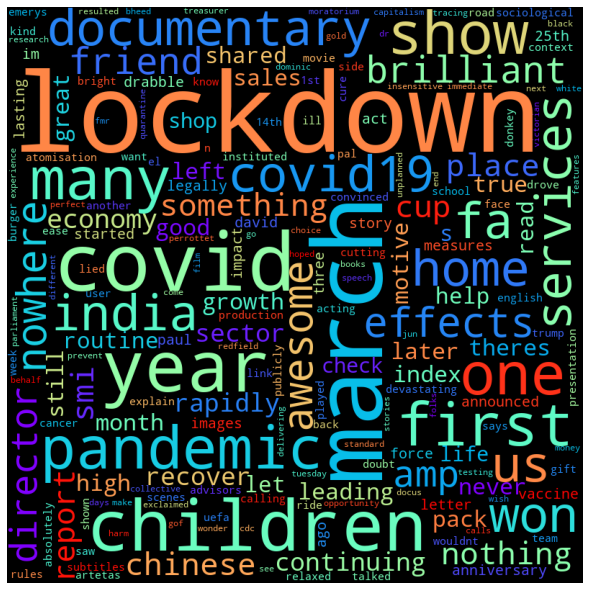

In [23]:
# Positive Sentiment DataFrame

positive = tweets[tweets['sentiment_label'] == 'positive']
generate_word_cloud(positive, 'positive')